Name: 吳泓毅

Student ID: 0716050

Dec 2020

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Input

將"train.json"和"test.json"讀進來並將ingredients用'|'分開連成string

In [2]:
train_data = pd.read_json("train.json")
train_data.ingredients = train_data.ingredients.apply(lambda l:'|'.join(l))
train_df = pd.DataFrame(data=train_data)
display(train_df)

test_data = pd.read_json("test.json")
test_data.ingredients = test_data.ingredients.apply(lambda l:'|'.join(l))
test_df = pd.DataFrame(data=test_data)
display(test_df)

,id,cuisine,ingredients
0,22675,italian,1% low-fat cottage cheese|low-fat marinara sau...
1,32288,southern_us,brown sugar|salt|eggs|butter|chopped pecans|pe...
2,44406,thai,red chili peppers|bell pepper|garlic|fish sauc...
3,29355,moroccan,water|green tea leaves|tangerine|fresh mint|su...
4,39350,chinese,vegetable oil|chile sauce|tomato paste|garlic ...
...,...,...,...
29769,2278,japanese,soy sauce|sesame oil|garlic|sake|flour|ground ...
29770,474,vietnamese,mint|garlic sauce|chinese chives|rice noodles|...
29771,44229,indian,potatoes|vegetable broth|oil|cashew nuts|peppe...
29772,20311,southern_us,"butter|powdered sugar|cream cheese, soften|van..."


,id,ingredients
0,10210,barbecue sauce|yellow onion|prepared pizza cru...
1,2310,olive oil|stewed tomatoes|hot sauce|chicken br...
2,33213,chopped bell pepper|cilantro leaves|white onio...
3,16902,tomatoes|purple onion|cumin seed|red lentils|v...
4,9056,chile powder|lime|blackpepper|ground cloves|ol...
...,...,...
9995,5759,romano cheese|parmesan cheese|basil|onions|egg...
9996,47786,lime juice|sugar|garlic chili sauce|water|fish...
9997,37976,dried fruit|sugar|water
9998,42429,eggs|whole wheat flour|all-purpose flour|warm ...


# 2. Data Preprocessing

## Shuffle the Data

將資料打亂並將index重設（從0開始）

In [3]:
from sklearn.utils import shuffle

train_df = shuffle(train_df)
train_df = train_df.reset_index(drop=True)

In [4]:
train_df

,id,cuisine,ingredients
0,23885,italian,turkey breast cutlets|olive oil|basil|black pe...
1,23591,indian,tomatoes|mustard seeds|salt|jaggery|red chili ...
2,34170,japanese,sake|ground black pepper|garlic|olive oil|miri...
3,22263,mexican,vegetable oil cooking spray|chicken breasts|ga...
4,2341,mexican,avocado|vegetable oil|chopped onion|black bean...
...,...,...,...
29769,44540,vietnamese,fish sauce|shallots|coconut|garlic cloves|pork...
29770,34314,brazilian,ice cubes|granulated sugar|lime|cold water
29771,4131,indian,tumeric|garlic|cumin seed|toor dal|garam masal...
29772,29647,mexican,extra-virgin olive oil|white onion|fresh lime ...


利用label encoder將cuisine改為用數字表示

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
train_df["cuisine"] = le.fit_transform(train_df["cuisine"])
train_df

,id,cuisine,ingredients
0,23885,9,turkey breast cutlets|olive oil|basil|black pe...
1,23591,7,tomatoes|mustard seeds|salt|jaggery|red chili ...
2,34170,11,sake|ground black pepper|garlic|olive oil|miri...
3,22263,13,vegetable oil cooking spray|chicken breasts|ga...
4,2341,13,avocado|vegetable oil|chopped onion|black bean...
...,...,...,...
29769,44540,19,fish sauce|shallots|coconut|garlic cloves|pork...
29770,34314,0,ice cubes|granulated sugar|lime|cold water
29771,4131,7,tumeric|garlic|cumin seed|toor dal|garam masal...
29772,29647,13,extra-virgin olive oil|white onion|fresh lime ...


將train和test中的ingredients存成一個list以便做tfidf vectorize

In [6]:
str_ing = train_df.ingredients.tolist()
str_ing += test_df.ingredients.tolist()

利用tfidfvectorizer判斷一個料理裡有沒有某種ingredients，X為sparse metrix，可直接用作training X，fit model時會比加回dataframe在分出來的X fit快上很多，此處加回是方便ANN使用

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
z = vectorizer.fit_transform(str_ing)
colnames = vectorizer.get_feature_names()
r = pd.DataFrame(z.toarray(), columns=colnames)

# print(z)
X = z[:29774]
# print(X)

X_test = z[29774:]
# print(X_test)

train_df = train_df.iloc[:,:2].join(r.iloc[:29774,:])
# display(train_df)

test_df = test_df.iloc[:,:1].join(r.iloc[29774:,:].reset_index(drop=True))
# display(test_df)

# 3. Model Construction

## Support Vector Machine

利用sklearn.svm裡的SVC建立三種不同kernel的svm

In [8]:
from sklearn.svm import SVC

svmrbf = SVC(kernel='rbf', cache_size=10000)

svmlin = SVC(kernel='linear', cache_size=10000)

svmsig = SVC(kernel='sigmoid', cache_size=10000)

## Artificial Neural Networks

利用keras建立nn

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,Flatten,Dropout
from keras.losses import categorical_crossentropy
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop
from keras import backend

利用Sequential疊加ANN的層數。input_dim=6703，是ingredients的種類；output layer的unit=20是cuisine的種類。中間加五層隱藏層。輸入層和隱藏層使用relu，最後輸出曾使用softmax。最後再compile這個ANN。

In [10]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 2000, kernel_initializer = "uniform",
                     activation = "relu", input_dim = 6703))

# Adding the second hidden layer
classifier.add(Dense(units = 500, kernel_initializer = "uniform",
                     activation = "relu"))

# Add drop out to reduce overfitting
classifier.add(Dropout(0.3))

# Adding the third hidden layer
classifier.add(Dense(units = 250, kernel_initializer = "uniform",
                     activation = "relu"))

# Adding the fourth hidden layer
classifier.add(Dense(units = 125, kernel_initializer = "uniform",
                     activation = "relu"))

# Add drop out to reduce overfitting
classifier.add(Dropout(0.3))

# Adding the fifth hidden layer
classifier.add(Dense(units = 50, kernel_initializer = "uniform",
                     activation = "relu"))

# Adding the output layer
classifier.add(Dense(units = 20, kernel_initializer = "uniform",
                     activation = "softmax"))

# Compiling the ANN
classifier.compile(optimizer = RMSprop(lr=0.0005), loss = "categorical_crossentropy",
                   metrics = ["accuracy"])

## Validation

利用train_test_split把training data分成training subset跟validation subset

In [11]:
from sklearn.model_selection import train_test_split
y = train_df.iloc[:,1].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

train_test_split前先將y進行One Hot Encode，讓ANN可以train

In [12]:
X_1h = train_df.iloc[:,2:]

onehot_encoder = OneHotEncoder(sparse=False)
y_1h = y.reshape(len(y), 1)
y_1h = onehot_encoder.fit_transform(y_1h)

X_train_1h, X_val_1h, y_train_1h, y_val_1h = train_test_split(X_1h, y_1h, test_size = 0.3)

# 4. Results

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## SVM

train data and generate confusion matrix and classification report


### kernel = rbf

In [14]:
svmrbf.fit(X_train, y_train)
y_pred_svmrbf = svmrbf.predict(X_val)

cm_svmrbf = confusion_matrix(y_val, y_pred_svmrbf)
print('Confusion matrix\n', cm_svmrbf)

print(classification_report(y_val, y_pred_svmrbf))

Confusion matrix
 [[  39    0    2    0    4    3    0    2    1   12    0    0    0   30
     0    0   11    0    6    0]
 [   0   40    0    1    0   28    0    6    7   27    0    0    1    1
     0    0   62    0    0    0]
 [   0    1  223    0    0   17    0    1    0   23    0    0    0   10
     0    0   58    0    0    0]
 [   0    1    0  499    2    6    0    2    0   19    0   11    6    4
     0    1   18    0    9    2]
 [   0    1    0   21   93    5    0    2    1   14    0    1    2    8
     0    0   18    4    6    5]
 [   0    2    4    1    0  361    2    0    3  168    0    1    0    4
     0    0   41    8    0    0]
 [   0    0    0    1    0    8  144    6    0   76    0    0    0    1
     3    0   12    1    0    0]
 [   0    0    0    3    1    2    1  618    0   17    0    0    0   22
    11    1   15    0    8    0]
 [   0    4    1    1    0   27    0    0   39   25    0    0    0    2
     1    0   38    0    0    0]
 [   0    1    4    1    0   77   11 

### kernel = linear

In [15]:
svmlin.fit(X_train, y_train)
y_pred_svmlin = svmlin.predict(X_val)

cm_svmlin = confusion_matrix(y_val, y_pred_svmlin)
print('Confusion matrix\n', cm_svmlin)

print(classification_report(y_val, y_pred_svmlin))

Confusion matrix
 [[  49    0    2    0    3    4    0    4    2    8    0    0    0   23
     0    0    8    0    7    0]
 [   0   71    0    1    0   24    0    6   10   16    0    0    1    1
     0    0   42    1    0    0]
 [   0    2  233    1    0   15    1    3    0   23    0    0    0   10
     0    0   45    0    0    0]
 [   0    1    2  492    2    7    0    2    0   13    0   12   14    5
     0    1   11    0   13    5]
 [   3    1    1   15  106    7    0    3    2    7    0    2    2    5
     0    0   14    4    4    5]
 [   0    8    6    1    2  379    2    0    7  131    0    1    0    4
     0    2   44    8    0    0]
 [   0    0    0    1    0   13  159    5    0   56    0    0    0    4
     3    0    9    2    0    0]
 [   0    0    0    3    2    4    1  621    0    8    0    3    0   17
    14    2   13    3    7    1]
 [   0   14    1    1    0   25    0    2   50   11    0    0    0    1
     1    1   31    0    0    0]
 [   0    4    6    0    2   99   13 

### kernel = sigmoid

In [16]:
svmsig.fit(X_train, y_train)
y_pred_svmsig = svmsig.predict(X_val)

cm_svmsig = confusion_matrix(y_val, y_pred_svmsig)
print('Confusion matrix\n', cm_svmsig)

print(classification_report(y_val, y_pred_svmsig))

Confusion matrix
 [[  48    0    3    0    4    4    0    4    2    6    0    0    0   24
     0    0    8    0    7    0]
 [   0   65    0    1    0   28    0    6   10   14    0    0    1    1
     0    0   45    2    0    0]
 [   0    2  228    0    0   16    0    3    0   23    0    0    0   11
     0    0   50    0    0    0]
 [   0    1    1  492    2    6    0    3    0   15    0   12   13    6
     0    1   12    0   12    4]
 [   2    0    1   15  109    6    0    3    1    6    0    2    2    5
     0    0   15    4    5    5]
 [   0    5    7    1    3  375    2    0    8  137    0    1    0    4
     0    3   42    7    0    0]
 [   0    0    0    1    0   12  154    5    0   62    0    0    0    3
     3    0   10    2    0    0]
 [   0    0    0    4    3    5    1  618    0    7    0    2    0   18
    14    2   15    3    6    1]
 [   0   15    1    1    0   27    0    1   49    9    0    0    0    1
     1    1   32    0    0    0]
 [   0    2    4    1    2  104   14 

## ANN

train data and generate confusion matrix and classification report

In [17]:
classifier.fit(X_train_1h, y_train_1h, batch_size = 10, epochs = 10)

Epoch 1/10
2085/2085 [==============================] - 226s 107ms/step - loss: 2.1715 - accuracy: 0.2943
Epoch 2/10
2085/2085 [==============================] - 219s 105ms/step - loss: 1.4171 - accuracy: 0.5557
Epoch 3/10
2085/2085 [==============================] - 219s 105ms/step - loss: 1.1208 - accuracy: 0.6706
Epoch 4/10
2085/2085 [==============================] - 219s 105ms/step - loss: 0.9595 - accuracy: 0.7343 - loss: 0.9596 - 
Epoch 5/10
2085/2085 [==============================] - 222s 106ms/step - loss: 0.7993 - accuracy: 0.7856
Epoch 6/10
2085/2085 [==============================] - 220s 106ms/step - loss: 0.6864 - accuracy: 0.8293
Epoch 7/10
2085/2085 [==============================] - 219s 105ms/step - loss: 0.6016 - accuracy: 0.8599
Epoch 8/10
2085/2085 [==============================] - 219s 105ms/step - loss: 0.5449 - accuracy: 0.8791
Epoch 9/10
2085/2085 [==============================] - 213s 102ms/step - loss: 0.5192 - accuracy: 0.8980
Epoch 10/10
2085/2085 [=====

In [18]:
y_pred_ann = classifier.predict(X_val_1h)

In [19]:
from sklearn.metrics import accuracy_score
y_pred_ann = [np.argmax(i) for i in y_pred_ann]

y_val_1h = [np.argmax(i) for i in y_val_1h]
accuracy = accuracy_score(y_val_1h, y_pred_ann)

In [20]:
cm_ann = confusion_matrix(y_val_1h, y_pred_ann)
print('Confusion matrix\n', cm_ann)

print(classification_report(y_val_1h, y_pred_ann))

Confusion matrix
 [[  52    0    1    0    5    4    1    2    0    5    0    0    0   14
     0    1    9    3    3    0]
 [   0   57    0    1    2   24    2    8   20   15    3    1    1    1
     0    2   15    1    1    0]
 [   1    1  237    0    2    7    0    1    0   22    0    0    0   11
     0    0   53    5    0    0]
 [   2    0    0  501    8    3    1    3    2    4    1   12   27    8
     0    0    6    2   20    7]
 [   4    0    0   15   97    4    0    3    0    3    2    1    3    6
     0    1    4    0   11   11]
 [   1   10   10    1    2  318    6    8    9  166    2    1    1    7
     4   11   35   11    2    0]
 [   1    1    0    0    0    6  180    8    2   42    0    0    0    3
     3    0    4    7    0    0]
 [   1    3    1    1    1    0    4  607    1    5    3    3    1    6
    16    0    4    1   14    1]
 [   0   25    0    2    4   17    1    2   56   20    1    3    0    3
     2    9   16    0    0    0]
 [   0    7   14    0    2   66   17 

# 5. Comparison & Conclusion

SVM with linear kernel performs best among the 3 SVMs and ANN

# 6. Retrain & Output

用svn (linear) retrain 整個train.json，並對test.json進行predict，最後輸出成csv

In [24]:
svmlin.fit(X, y)
y_pred = svmlin.predict(X_test)
y_pred = le.inverse_transform([i for i in y_pred]) 

out_df = test_df.iloc[:,0].to_frame()
out_df['Category'] = y_pred

out_df.to_csv('y_test.csv', index=False)

## Screenshot of the Leaderboard

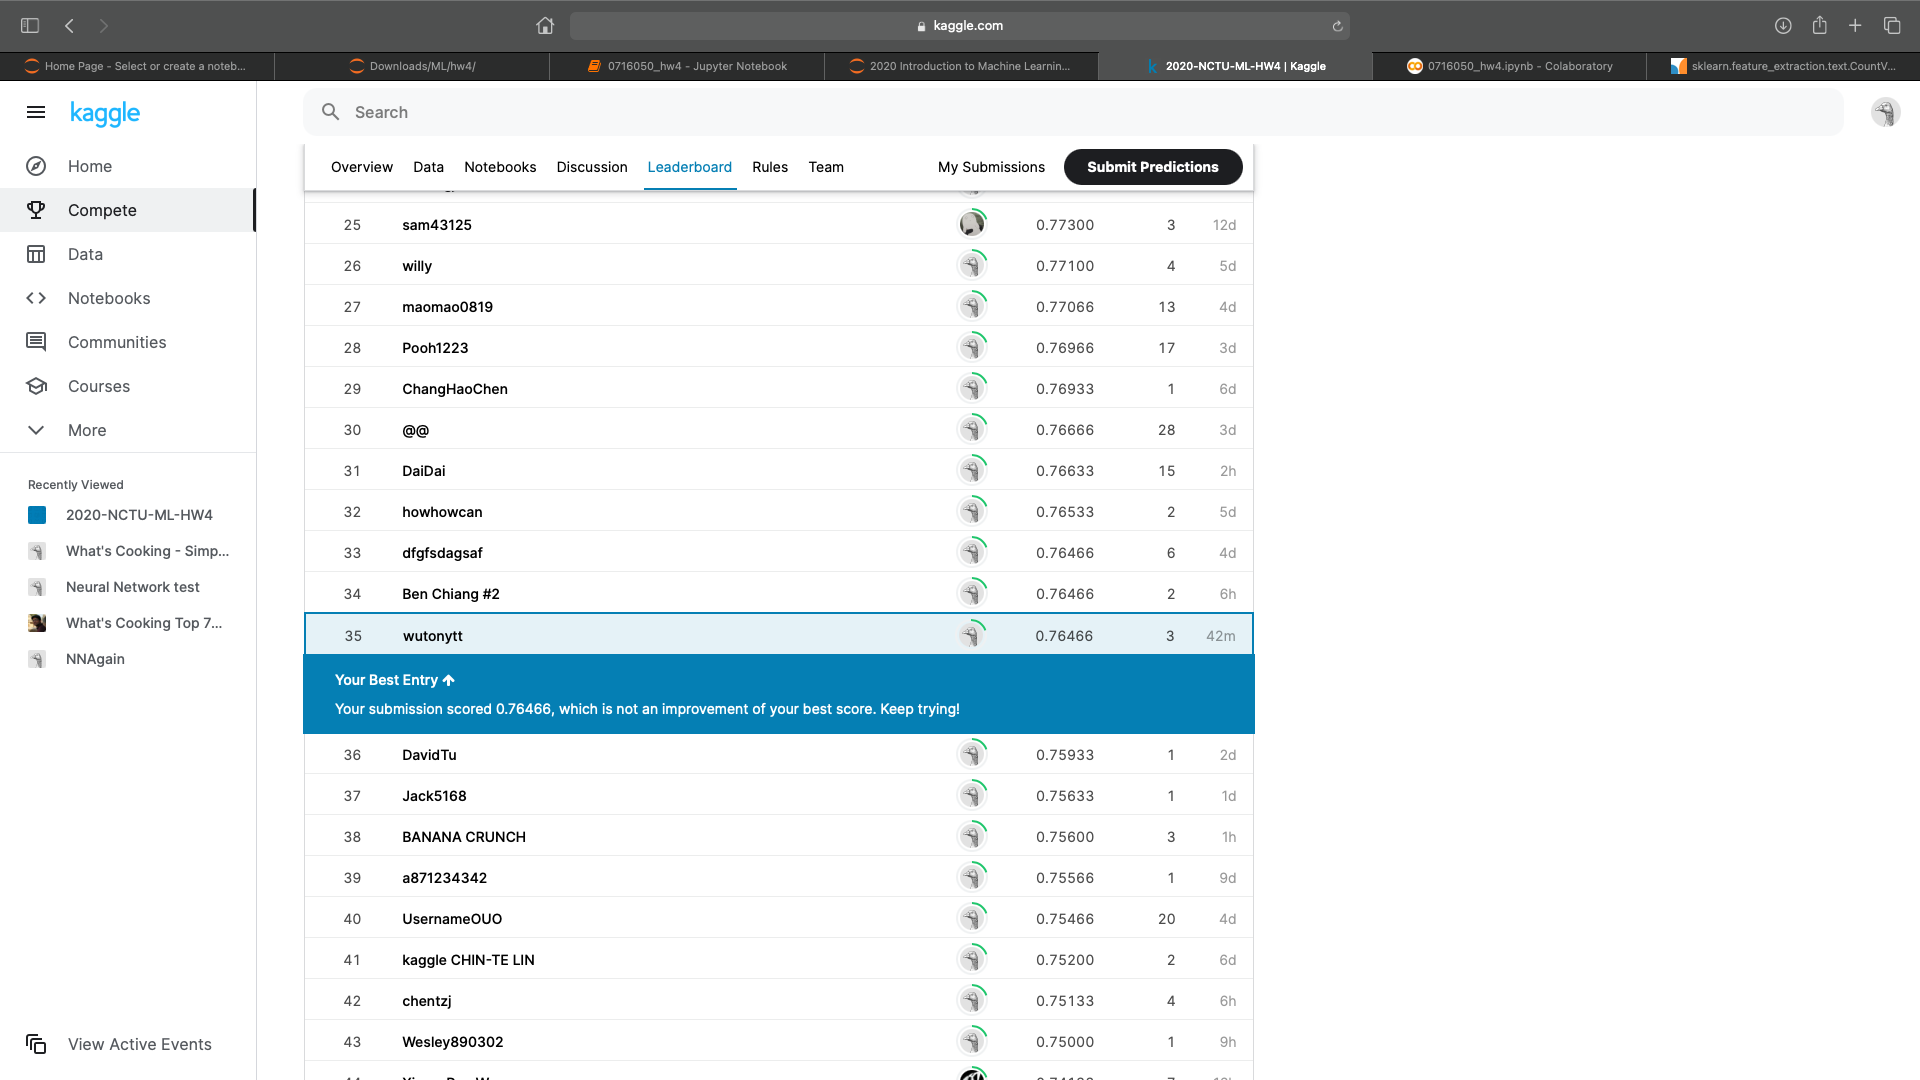

In [26]:
from IPython.display import Image

Image(filename = "Leaderboard.png")